#**유통 판매량 예측 및 재고 최적화**
## **단계1 : 데이터 탐색 및 가설 도출**

# **0.미션**

* 예측해야 할 핵심상품 역할 분담
    * 핵심상품 별로, 데이터 탐색, 가설수립, 데이터셋 구성
    * 1인당 1~2개 정도를 분담하여 개별 과제 수행
    * 팀 미팅을 통해 진행 사항 공유 및 취합

* 데이터 탐색 및 가설 도출
    * 주어진 데이터에 대해 대상 매장, 대상 상품의 그래프 그리고 시계열 패턴을 찾기
    * 찾은 패턴을 기반으로 가설 도출

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/KT Aivle/Mini Project 6-1/'

### **(2) 라이브러리 설치 및 불러오기**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

### **(3) 데이터 불러오기**

#### 1) 데이터로딩

In [ ]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

#### 2) 기본 정보 조회

In [ ]:
# 데이터 기간
print('start_date:', sales['Date'].min(), '\nend_date:', sales['Date'].max())
start_date = '2014-01-01'
end_date = '2017-02-28'

start_date: 2014-01-01 00:00:00 
end_date: 2017-02-28 00:00:00


→ 3년 2개월치 데이터

In [ ]:
oil_price.head(5)

,Date,WTI_Price
0,2014-01-01,NaN
1,2014-01-02,95.14
2,2014-01-03,93.66
3,2014-01-06,93.12
4,2014-01-07,93.31


In [ ]:
orders.head(5)

,Date,Store_ID,CustomerCount
0,2014-01-01,25,840
1,2014-01-01,36,487
2,2014-01-02,1,1875
3,2014-01-02,2,2122
4,2014-01-02,3,3350


In [ ]:
sales.head(5)

,Date,Store_ID,Qty,Product_ID
0,2014-01-01,1,0.0,3
1,2014-01-01,1,0.0,5
2,2014-01-01,1,0.0,7
3,2014-01-01,1,0.0,8
4,2014-01-01,1,0.0,10


In [ ]:
products.head(5)

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
0,20,HG001,Gardening Tools,Household Goods,2,50
1,27,HH001,Home Appliances,Household Goods,2,150
2,16,HK001,Kitchen,Household Goods,2,23
3,15,HK002,Kitchen,Household Goods,2,41
4,32,GS001,Seafood,Grocery,3,34


In [ ]:
stores.head(5)

,Store_ID,City,State,Store_Type
0,1,Saint Paul,\tMinnesota,4
1,2,Saint Paul,\tMinnesota,4
2,3,Saint Paul,\tMinnesota,4
3,4,Saint Paul,\tMinnesota,4
4,5,Oklahoma City,Oklahoma,4


In [ ]:
products[products['Product_ID']==42]

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
15,42,FM001,Agricultural products,Grocery,2,5


In [ ]:
stores[stores['Store_ID']==44]

,Store_ID,City,State,Store_Type
43,44,Saint Paul,\tMinnesota,1


In [ ]:
#BEVERAGE_ID = 3
#MILK_ID = 12
AGRICULTURAL_PRODUCTS_ID = 42
STORE_ID = 44

In [ ]:
# Store_ID가 44인 판매 데이터만 추출
my_sales = sales.loc[sales['Store_ID'] == STORE_ID, :]
my_sales

,Date,Store_ID,Qty,Product_ID
645,2014-01-01,44,0.000,3
646,2014-01-01,44,0.000,5
647,2014-01-01,44,0.000,7
648,2014-01-01,44,0.000,8
649,2014-01-01,44,0.000,10
...,...,...,...,...
934120,2017-02-28,44,1057.687,24
934121,2017-02-28,44,79.000,27
934122,2017-02-28,44,87.000,42
934123,2017-02-28,44,607.427,29


In [ ]:
# Store_ID가 44인 방문 고객(구매 고객) 데이터만 추출
my_orders = orders.loc[orders['Store_ID'] == STORE_ID, :]
my_orders

,Date,Store_ID,CustomerCount
39,2014-01-02,44,4422
86,2014-01-03,44,4167
133,2014-01-04,44,5341
180,2014-01-05,44,5123
227,2014-01-06,44,3917
...,...,...,...
57336,2017-02-24,44,4549
57389,2017-02-25,44,4619
57442,2017-02-26,44,3877
57495,2017-02-27,44,3961


In [ ]:
#b_sales = my_sales.loc[sales['Product_ID'] == BEVERAGE_ID, :]
#m_sales = my_sales.loc[sales['Product_ID'] == MILK_ID, :]
a_sales = my_sales.loc[sales['Product_ID'] == AGRICULTURAL_PRODUCTS_ID, :]

In [ ]:
# 농작물 판매량
a_sales

,Date,Store_ID,Qty,Product_ID
658,2014-01-01,44,51.0,42
1469,2014-01-02,44,76.0,42
2280,2014-01-03,44,74.0,42
3091,2014-01-04,44,78.0,42
3902,2014-01-05,44,88.0,42
...,...,...,...,...
930878,2017-02-24,44,91.0,42
931689,2017-02-25,44,105.0,42
932500,2017-02-26,44,108.0,42
933311,2017-02-27,44,78.0,42


# **2.데이터 탐색**

* 시계열 패턴을 찾아보기 위한 그래프를 그려 봅시다.

## **(1) 시계열 패턴 찾아보기1**

* 다음 항목은 패턴을 찾기 위한 예제 문항 입니다. 참조하여 시계열 패턴을 찾아 봅시다.
    * 대상 매장(44), 대상 상품(3,12,42)의 판매량 추이
    * 대상 상품의 동일 카테고리의 상품별 판매량 추이 (우유 → 유제품)
    * 휘발류 가격과 상품 판매량 추이 비교
    * 방문 고객수와 상품 판매량 추이 비교
    * 그외...

### 1) 대상 매장(44), 대상 상품의 판매량 추이 - 농작물

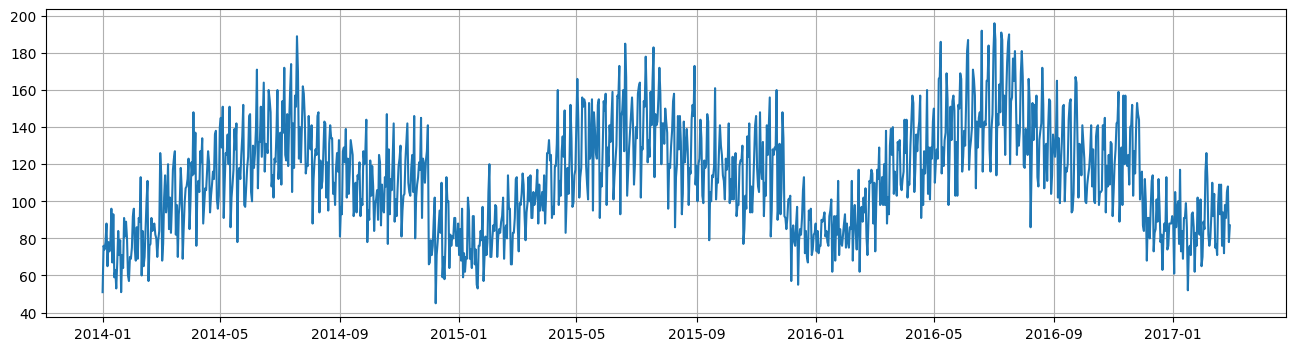

In [ ]:
# 전체 데이터
plt.figure(figsize = (16,4))
plt.plot('Date', 'Qty', data = a_sales)
plt.grid()
plt.show()

→ 계절성 띔

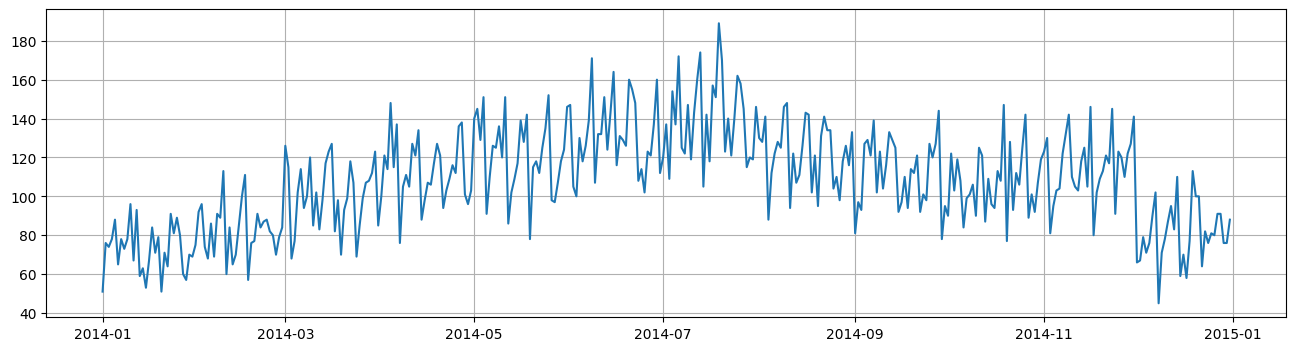

In [ ]:
# 1년치 데이터
plt.figure(figsize = (16,4))
plt.plot('Date', 'Qty', data = a_sales[:365])
plt.grid()
plt.show()

판매량은 봄에 증가, 여름에 최대, 가을에 어느정도 증가, 겨울에 최소

※ 가설) 기후에 따라, 농작물 생산량이 증가하는 여름에 판매량이 증가, 겨울에 감소한 것일 것이며, 수요량에도 영향 줬을 것이다.

### 2) 대상 상품의 동일 카테고리의 상품별 판매량 추이

In [ ]:
print(products.loc[products['Product_ID'] == AGRICULTURAL_PRODUCTS_ID, 'Category'].iloc[0])

Grocery


In [ ]:
products.loc[products['Category'] == 'Grocery', :]

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
4,32,GS001,Seafood,Grocery,3,34
8,10,GE001,EGGS,Grocery,2,5
9,24,GM001,Meats,Grocery,3,17
15,42,FM001,Agricultural products,Grocery,2,5


→ Seafood(32), EGGS(10), Meats(24)가 Agricultural products(42)와 Category가 같음

- Seafood

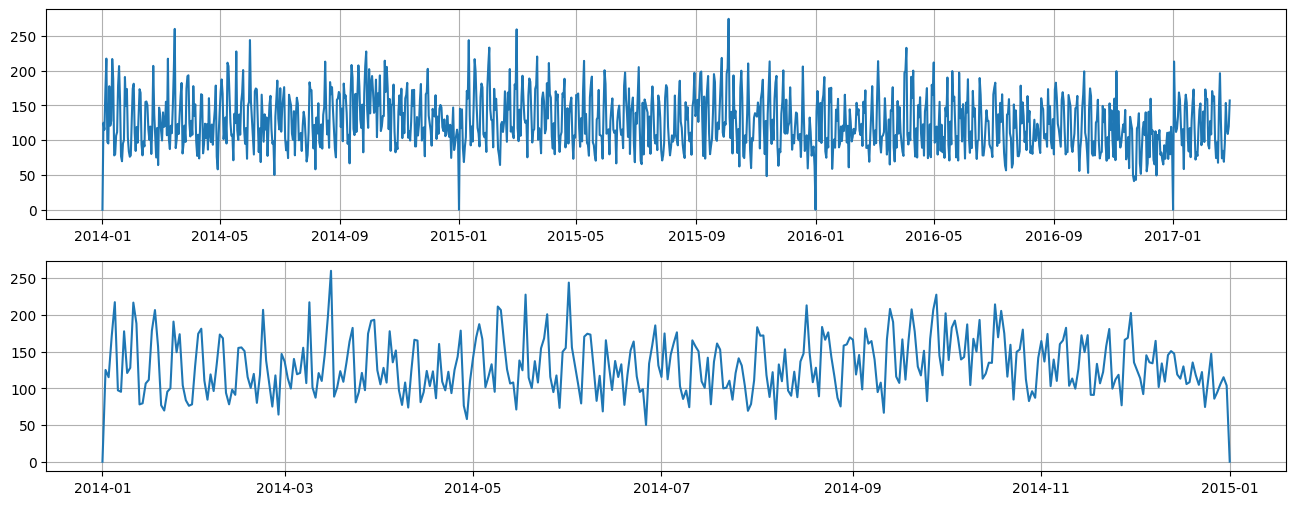

In [ ]:
# Seafood의 판매량 추이
s_sales = my_sales[my_sales['Product_ID'] == 32]
plt.figure(figsize = (16,6))

# 전체
plt.subplot(2,1,1)
plt.plot('Date', 'Qty', data = s_sales)
plt.grid()

# 1년치
plt.subplot(2,1,2)
plt.plot('Date', 'Qty', data = s_sales[:365])
plt.grid()

plt.show()

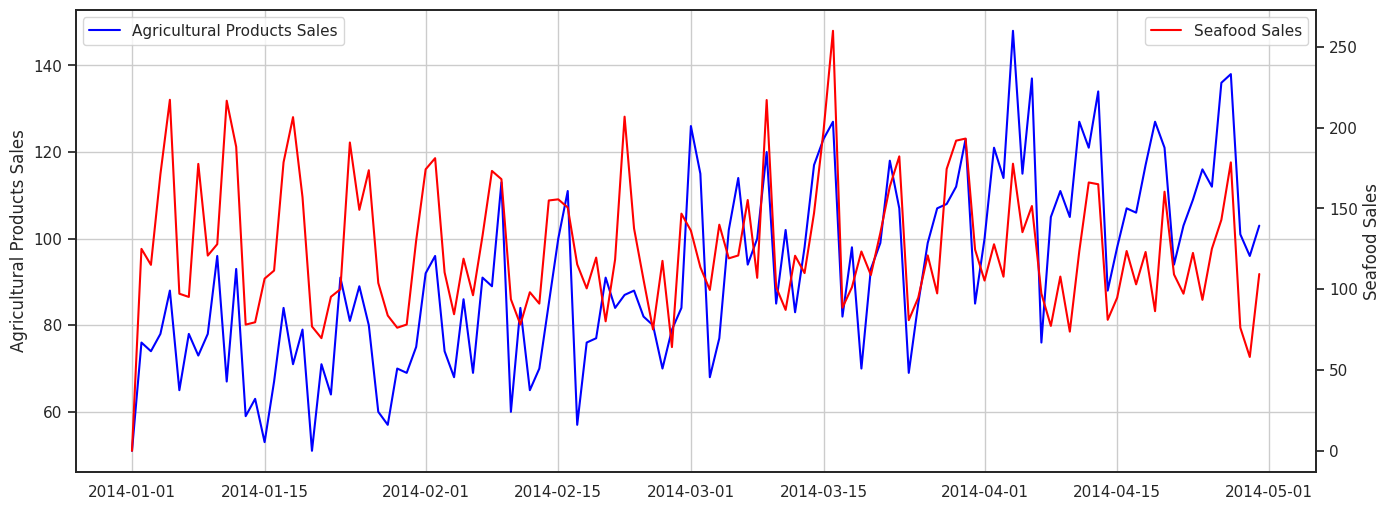

In [ ]:
# 두 데이터프레임 결합
merged_df = pd.merge(a_sales, s_sales, on='Date', how='inner', suffixes=('_a', '_s'))

# 시각화
plt.figure(figsize=(16,6))
plt.plot('Date', 'Qty_a', data=merged_df[:120], color='blue', label='Agricultural Products Sales')
plt.ylabel('Agricultural Products Sales')
plt.legend(loc='upper left')
plt.grid()

ax2 = plt.gca().twinx()
ax2.plot('Date', 'Qty_s', data=merged_df[:120], color='red', label='Seafood Sales')
ax2.set_ylabel('Seafood Sales')
ax2.legend(loc = 'upper right')

plt.show()

In [ ]:
import scipy.stats as spst

In [ ]:
# 상관계수와 p-value
spst.pearsonr(merged_df['Qty_a'], merged_df['Qty_s'])

PearsonRResult(statistic=0.2775856137295283, pvalue=7.945569606375991e-22)

- EGGS

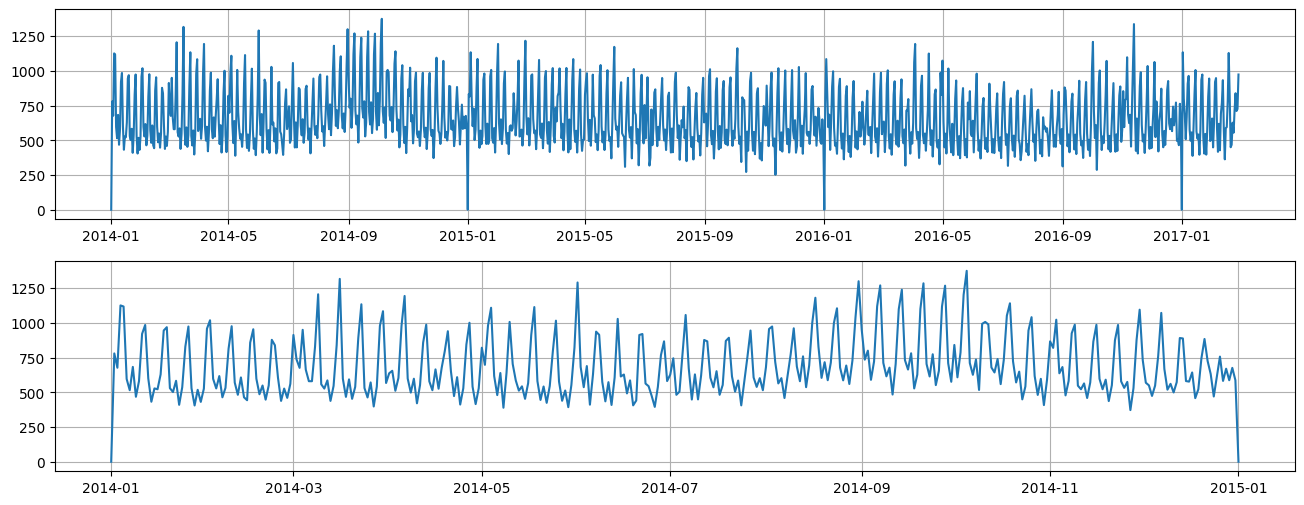

In [ ]:
# EGGS의 판매량 추이
e_sales = my_sales[my_sales['Product_ID'] == 10]
plt.figure(figsize = (16,6))

# 전체
plt.subplot(2,1,1)
plt.plot('Date', 'Qty', data = e_sales)
plt.grid()

# 1년치
plt.subplot(2,1,2)
plt.plot('Date', 'Qty', data = e_sales[:365])
plt.grid()

plt.show()

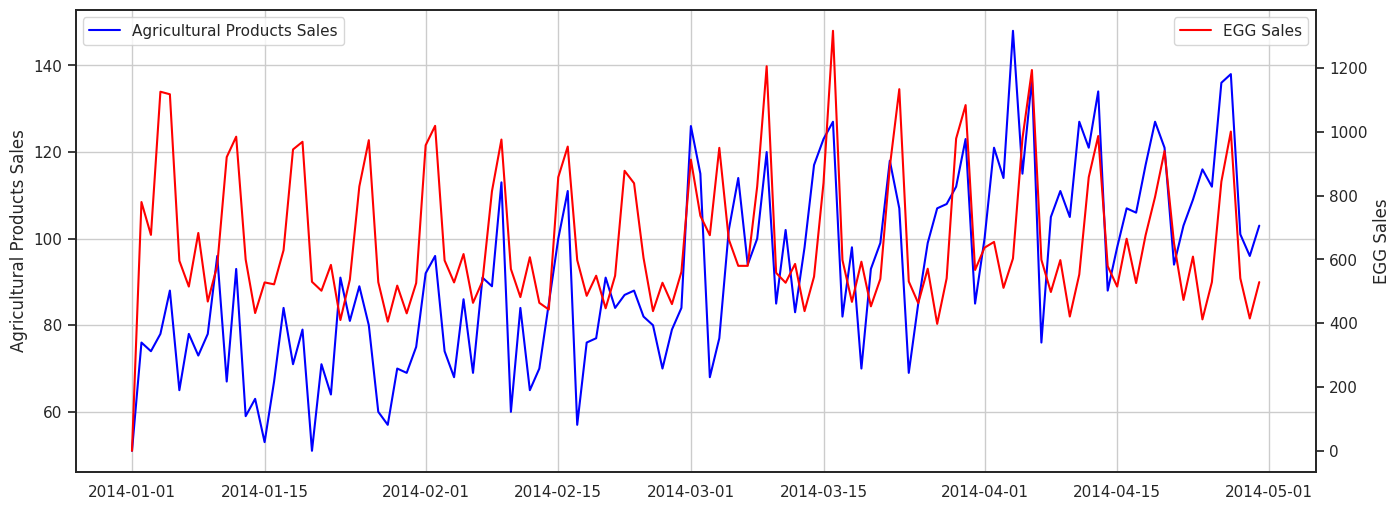

In [ ]:
# 두 데이터프레임 결합
merged_df = pd.merge(a_sales, e_sales, on='Date', how='inner', suffixes=('_a', '_e'))

# 시각화
plt.figure(figsize=(16,6))
plt.plot('Date', 'Qty_a', data=merged_df[:120], color='blue', label='Agricultural Products Sales')
plt.ylabel('Agricultural Products Sales')
plt.legend(loc='upper left')
plt.grid()

ax2 = plt.gca().twinx()
ax2.plot('Date', 'Qty_e', data=merged_df[:120], color='red', label='EGG Sales')
ax2.set_ylabel('EGG Sales')
ax2.legend(loc = 'upper right')

plt.show()

In [ ]:
# 상관계수와 p-value
spst.pearsonr(merged_df['Qty_a'], merged_df['Qty_e'])

PearsonRResult(statistic=0.251337823550119, pvalue=4.683647717526685e-18)

- Meats

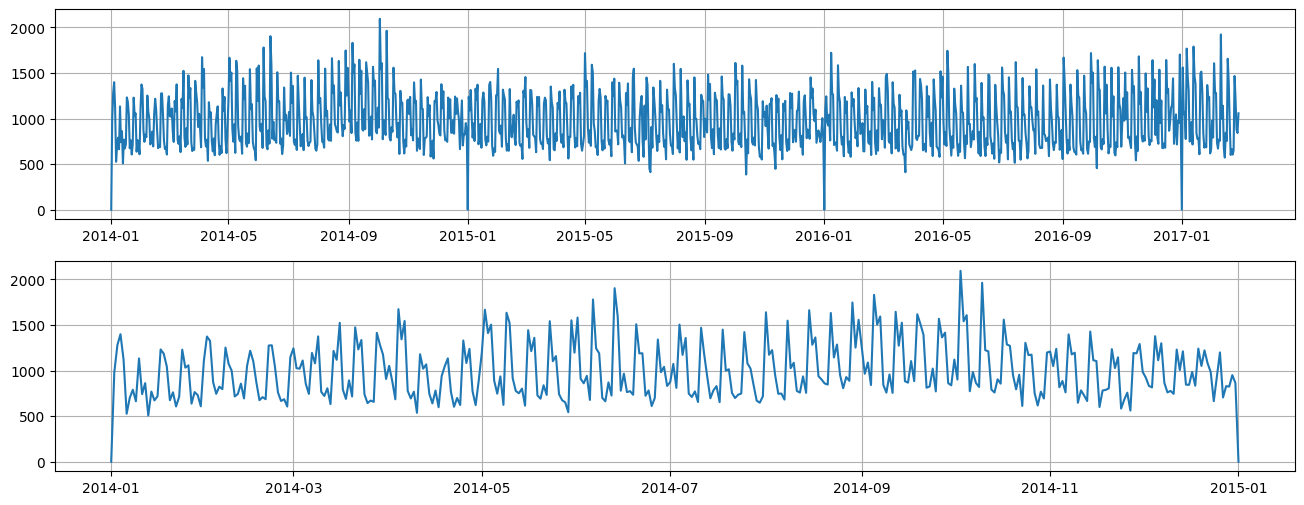

In [ ]:
# Meats의 판매량 추이
m_sales = my_sales[my_sales['Product_ID'] == 24]
plt.figure(figsize = (16,6))

# 전체
plt.subplot(2,1,1)
plt.plot('Date', 'Qty', data = m_sales)
plt.grid()

# 1년치
plt.subplot(2,1,2)
plt.plot('Date', 'Qty', data = m_sales[:365])
plt.grid()

plt.show()

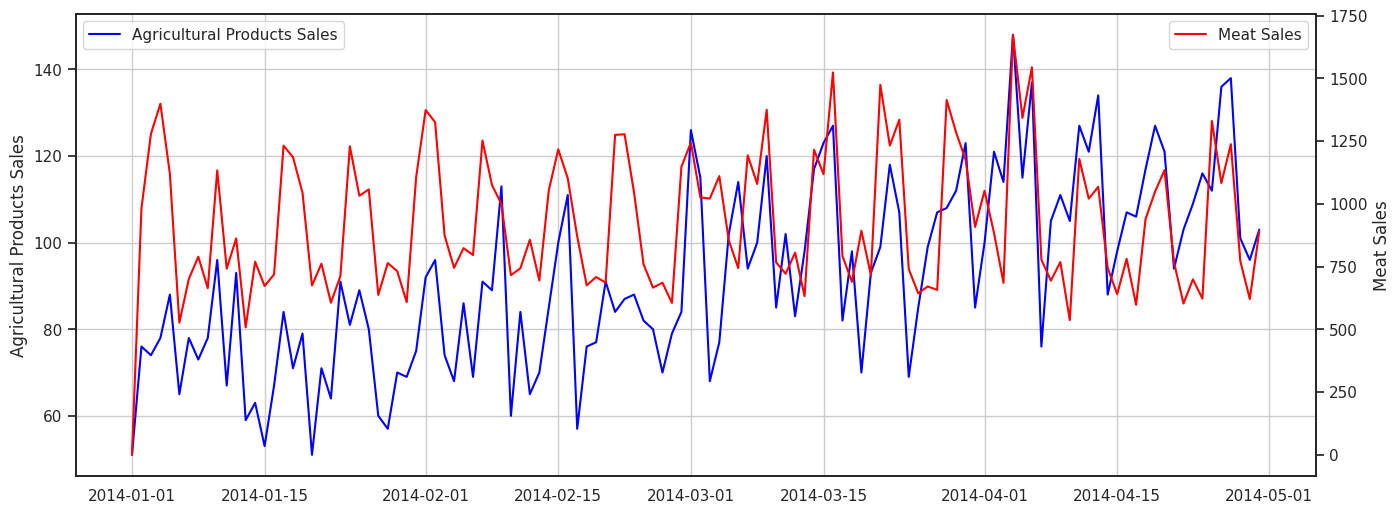

In [ ]:
# 두 데이터프레임 결합
merged_df = pd.merge(a_sales, m_sales, on='Date', how='inner', suffixes=('_a', '_m'))

# 시각화
plt.figure(figsize=(16,6))
plt.plot('Date', 'Qty_a', data=merged_df[:120], color='blue', label='Agricultural Products Sales')
plt.ylabel('Agricultural Products Sales')
plt.legend(loc='upper left')
plt.grid()

ax2 = plt.gca().twinx()
ax2.plot('Date', 'Qty_m', data=merged_df[:120], color='red', label='Meat Sales')
ax2.set_ylabel('Meat Sales')
ax2.legend(loc = 'upper right')

plt.show()

In [ ]:
# 상관계수와 p-value
spst.pearsonr(merged_df['Qty_a'], merged_df['Qty_m'])

PearsonRResult(statistic=0.29861085410263927, pvalue=3.7111782812835522e-25)

→ 각 해산물, 계란, 고기의 판매량은 계절과 무관하게 어느정도 일정한 분포를 띔(매월 1일에 0인 데이터가 있음 (결측치인듯))

→ 농작물과의 상관계수는 0.25~0.3 사이로 중간 정도의 상관계수를 띔

※ 가설) 해산물, 계란, 고기의 판매량이 증가할수록 농작물의 판매량도 증가할 것이다.

### 3) 휘발류 가격과 상품 판매량 추이 비교

In [ ]:
oil_price.isnull().sum()

Date          0
WTI_Price    30
dtype: int64

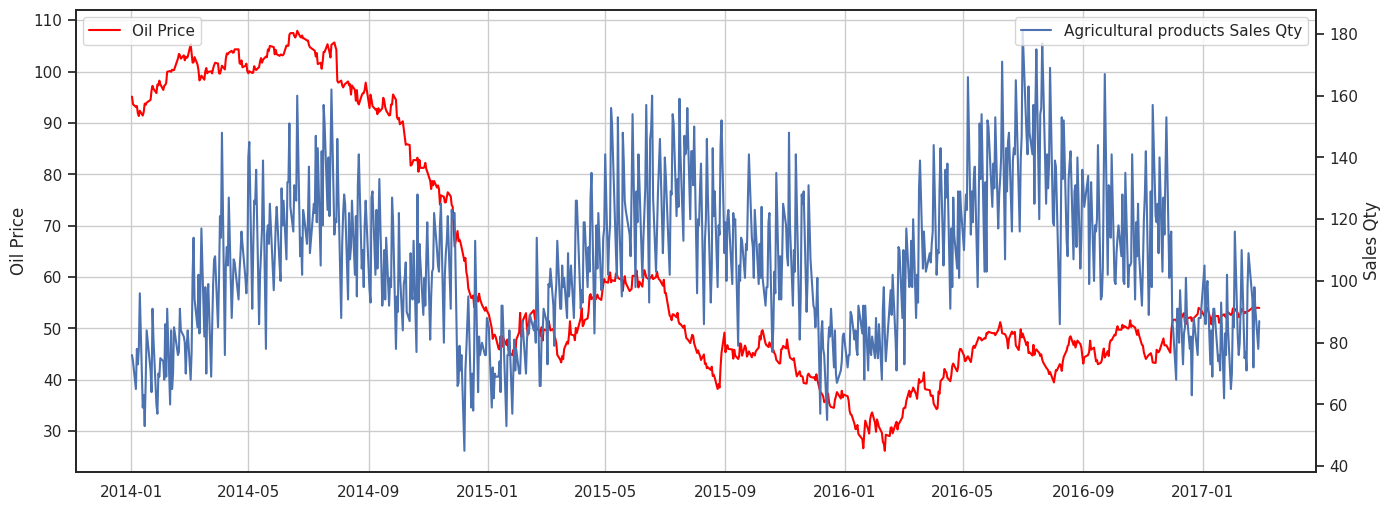

In [ ]:
# 두 데이터프레임 결합
merged_df = pd.merge(oil_price, a_sales, on='Date', how='inner')

# 결측치가 없는 행만 남기기
merged_df = merged_df.dropna()

# 시각화
plt.figure(figsize=(16,6))
plt.plot('Date', 'WTI_Price', data=merged_df, color='red', label='Oil Price')
plt.ylabel('Oil Price')
plt.legend(loc='upper left')
plt.grid()

ax2 = plt.gca().twinx()
ax2.plot('Date', 'Qty', data=merged_df, label='Agricultural products Sales Qty')
ax2.set_ylabel('Sales Qty')
ax2.legend(loc = 'upper right')

plt.show()

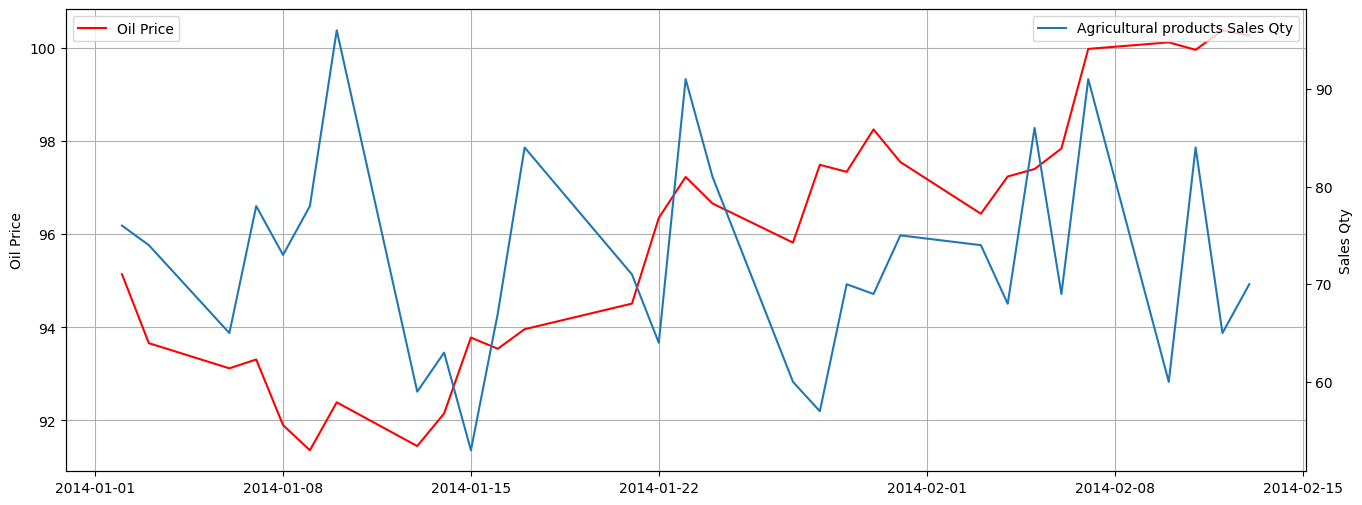

In [ ]:
# 자세히 보기

# 시각화
plt.figure(figsize=(16,6))
plt.plot('Date', 'WTI_Price', data=merged_df[:30], color='red', label='Oil Price')
plt.ylabel('Oil Price')
plt.legend(loc='upper left')
plt.grid()

ax2 = plt.gca().twinx()
ax2.plot('Date', 'Qty', data=merged_df[:30], label='Agricultural products Sales Qty')
ax2.set_ylabel('Sales Qty')
ax2.legend(loc = 'upper right')

plt.show()

미국은 땅이 넓어서 보통 마트까지의 거리가 멀기 때문에 유가에 민감

※ 가설) 유가가 높을수록 마트에 덜 방문할 것이기 때문에 판매량이 감소했을 것이다
...라고 생각했는데 딱히 아닌듯

In [ ]:
# 상관계수와 p-value
spst.pearsonr(merged_df['Qty'], merged_df['WTI_Price'])

PearsonRResult(statistic=-0.020468377920016854, pvalue=0.5644303705089716)

In [ ]:
oil_price

,Date,WTI_Price
0,2014-01-01,NaN
1,2014-01-02,95.14
2,2014-01-03,93.66
3,2014-01-06,93.12
4,2014-01-07,93.31
...,...,...
820,2017-02-22,53.61
821,2017-02-23,54.48
822,2017-02-24,53.99
823,2017-02-27,54.04


- 지난주 유가와 판매량

In [ ]:
# 7일 전 유가
n_days= 7

oil_price['Prev_WTI_Price'] = oil_price['WTI_Price'].shift(n_days)

# 전날과의 판매량 변화를 계산하여 새로운 컬럼에 추가
oil_price['Qty_Change'] = oil_price['WTI_Price'] - oil_price['Prev_WTI_Price']

# 결과 확인
oil_price.head(5)

,Date,WTI_Price,Prev_WTI_Price,Qty_Change
0,2014-01-01,NaN,NaN,NaN
1,2014-01-02,95.14,NaN,NaN
2,2014-01-03,93.66,NaN,NaN
3,2014-01-06,93.12,NaN,NaN
4,2014-01-07,93.31,NaN,NaN


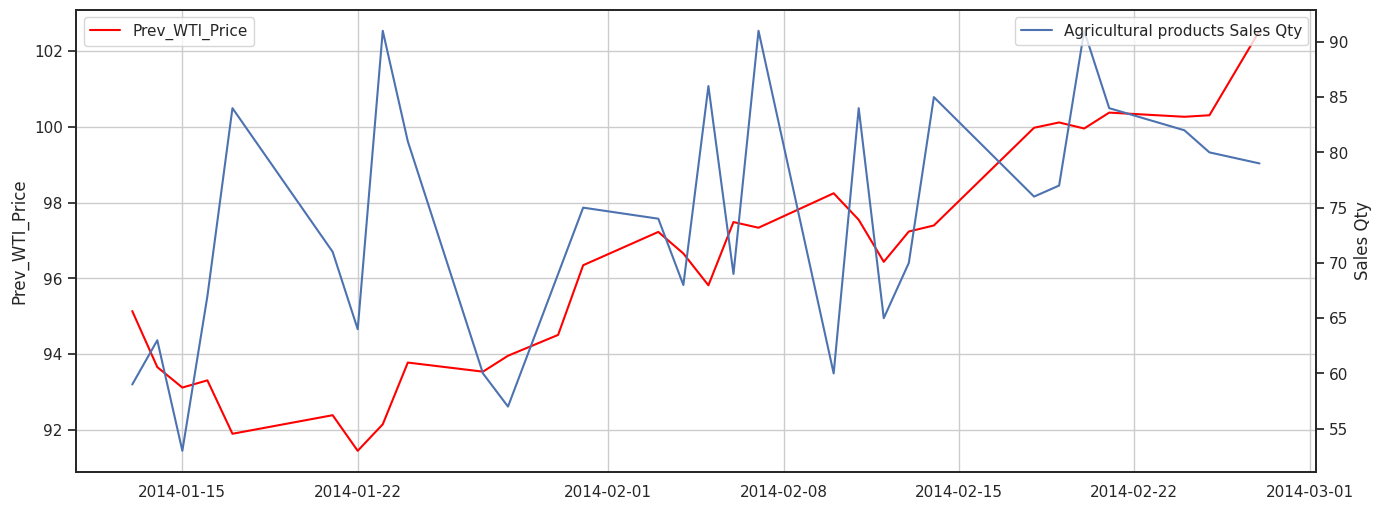

In [ ]:
# 두 데이터프레임 결합
merged_df = pd.merge(oil_price, a_sales, on='Date', how='inner')

# 결측치가 없는 행만 남기기
merged_df = merged_df.dropna()

# 시각화
plt.figure(figsize=(16,6))
plt.plot('Date', 'Prev_WTI_Price', data=merged_df[:30], color='red', label='Prev_WTI_Price')
plt.ylabel('Prev_WTI_Price')
plt.legend(loc='upper left')
plt.grid()

ax2 = plt.gca().twinx()
ax2.plot('Date', 'Qty', data=merged_df[:30], label='Agricultural products Sales Qty')
ax2.set_ylabel('Sales Qty')
ax2.legend(loc = 'upper right')

plt.show()

In [ ]:
# 상관계수와 p-value
spst.pearsonr(merged_df['Qty'], merged_df['Prev_WTI_Price'])

PearsonRResult(statistic=-0.02272422398013914, pvalue=0.5316342566864897)

→ 지난주 유가와도 농작물 판매량은 별 상관 X

### 4) 방문 고객수와 상품 판매량 추이 비교

In [ ]:
orders.isnull().sum()

Date             0
Store_ID         0
CustomerCount    0
dtype: int64

In [ ]:
orders

,Date,Store_ID,CustomerCount
0,2014-01-01,25,840
1,2014-01-01,36,487
2,2014-01-02,1,1875
3,2014-01-02,2,2122
4,2014-01-02,3,3350
...,...,...,...
57553,2017-02-28,49,3183
57554,2017-02-28,50,2651
57555,2017-02-28,51,1545
57556,2017-02-28,53,1141


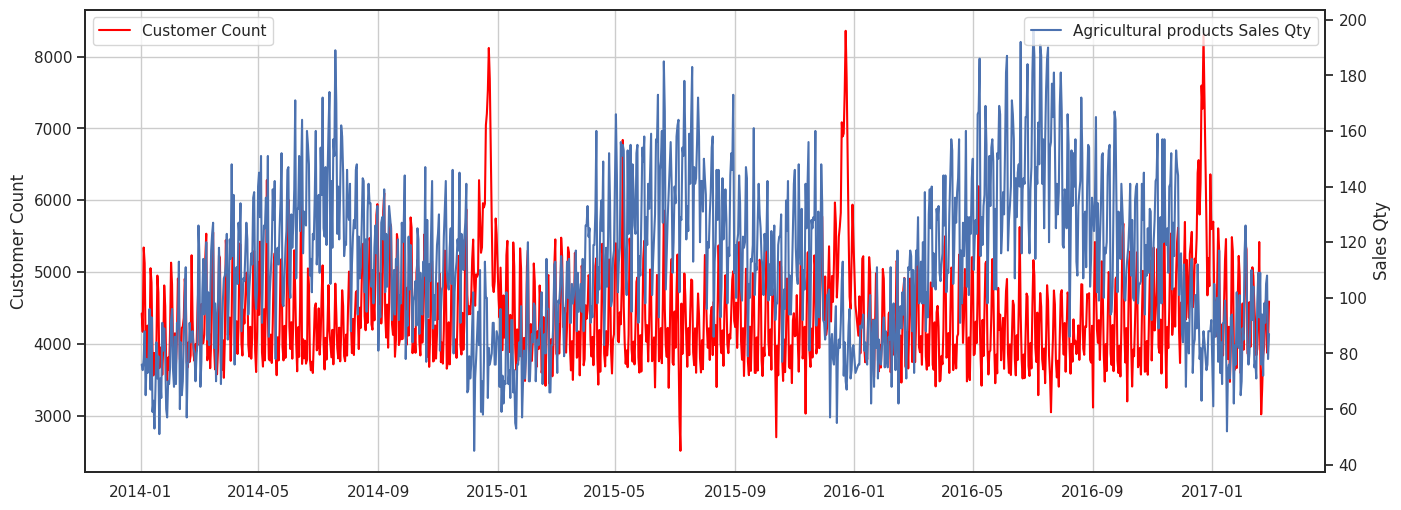

In [ ]:
# 두 데이터프레임 결합
merged_df = pd.merge(my_orders, a_sales, on='Date', how='inner')

# 시각화
plt.figure(figsize=(16,6))
plt.plot('Date', 'CustomerCount', data=merged_df, color='red', label='Customer Count')
plt.ylabel('Customer Count')
plt.legend(loc='upper left')
plt.grid()

ax2 = plt.gca().twinx()
ax2.plot('Date', 'Qty', data=merged_df, label='Agricultural products Sales Qty')
ax2.set_ylabel('Sales Qty')
ax2.legend(loc = 'upper right')

plt.show()

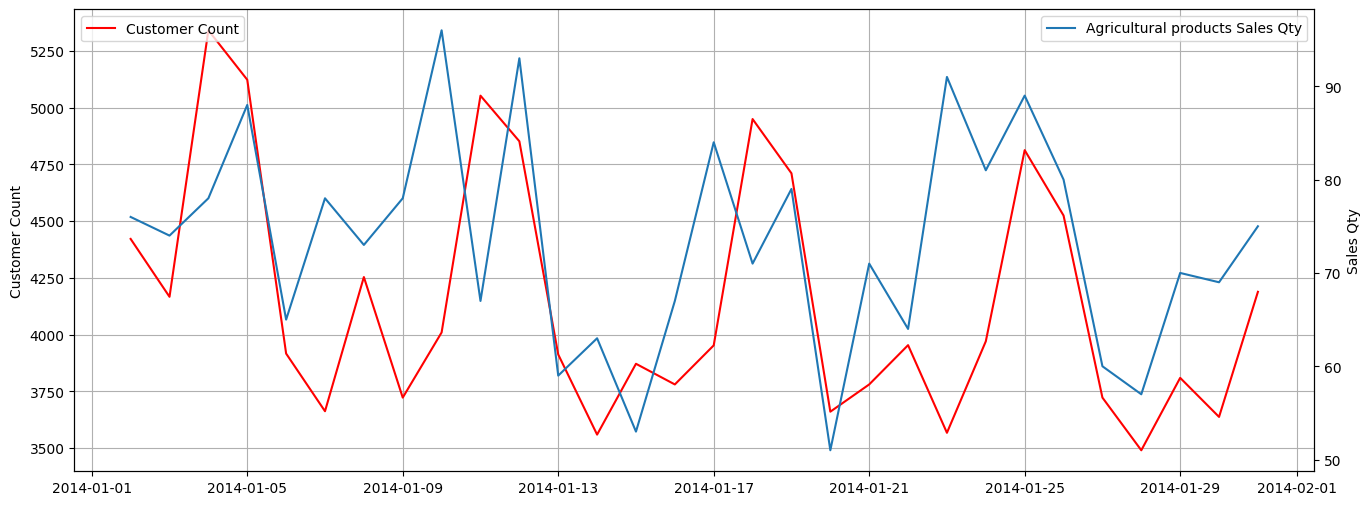

In [ ]:
# 자세히 보기

# 시각화
plt.figure(figsize=(16,6))
plt.plot('Date', 'CustomerCount', data=merged_df[:30], color='red', label='Customer Count')
plt.ylabel('Customer Count')
plt.legend(loc='upper left')
plt.grid()

ax2 = plt.gca().twinx()
ax2.plot('Date', 'Qty', data=merged_df[:30], label='Agricultural products Sales Qty')
ax2.set_ylabel('Sales Qty')
ax2.legend(loc = 'upper right')

plt.show()

In [ ]:
# 상관계수와 p-value
spst.pearsonr(merged_df['Qty'], merged_df['CustomerCount'])

PearsonRResult(statistic=0.09210307140472103, pvalue=0.0018013770066155725)

→ 당연히 방문 고객 많을수록 판매량 증가할 줄 알았는데 그렇진 않은듯

## **(2) 시계열 패턴 찾아보기2**

* 변화량과 비교해보기 (n일 전 판매량에 비해 오늘의 판매량)

### 1) 대상 매장(44), 대상 상품의 판매량 추이

In [ ]:
# 전날의 판매량
n_days= 1

a_sales['Prev_Qty'] = a_sales['Qty'].shift(n_days)

# 전날과의 판매량 변화를 계산하여 새로운 컬럼에 추가
a_sales['Qty_Change'] = a_sales['Qty'] - a_sales['Prev_Qty']

# 결과 확인
a_sales.head(5)

,Date,Store_ID,Qty,Product_ID,Weekday,Qty_Change,Prev_Qty
658,2014-01-01,44,51.0,42,2,NaN,NaN
1469,2014-01-02,44,76.0,42,3,25.0,51.0
2280,2014-01-03,44,74.0,42,4,-2.0,76.0
3091,2014-01-04,44,78.0,42,5,4.0,74.0
3902,2014-01-05,44,88.0,42,6,10.0,78.0


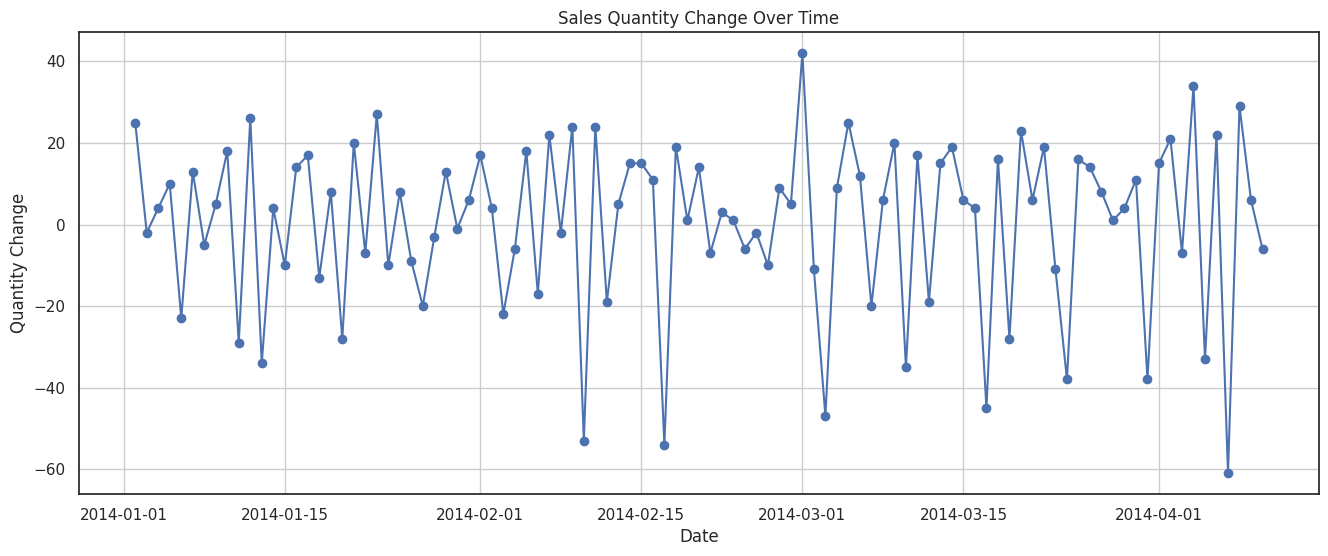

In [ ]:
plt.figure(figsize=(16, 6))

plt.plot('Date', 'Qty_Change', data = a_sales[:100], marker='o', linestyle='-')

plt.title('Sales Quantity Change Over Time')
plt.xlabel('Date')
plt.ylabel('Quantity Change')

plt.grid(True)

plt.show()

### 2) 요일별 변화량 비교

In [ ]:
a_sales

,Date,Store_ID,Qty,Product_ID,Weekday,Yesterday_Qty,Qty_Change
658,2014-01-01,44,51.0,42,2,NaN,NaN
1469,2014-01-02,44,76.0,42,3,51.0,25.0
2280,2014-01-03,44,74.0,42,4,76.0,-2.0
3091,2014-01-04,44,78.0,42,5,74.0,4.0
3902,2014-01-05,44,88.0,42,6,78.0,10.0
...,...,...,...,...,...,...,...
930878,2017-02-24,44,91.0,42,4,98.0,-7.0
931689,2017-02-25,44,105.0,42,5,91.0,14.0
932500,2017-02-26,44,108.0,42,6,105.0,3.0
933311,2017-02-27,44,78.0,42,0,108.0,-30.0


In [ ]:
# # 날짜에서 요일을 추출하여 새로운 컬럼에 추가
# a_sales['DayOfWeek'] = a_sales['Date'].dt.day_name() # 월(0)~일(6)

# 요일별 판매량을 그룹화하여 평균 계산
a_sales_w = a_sales.groupby('Weekday')['Qty'].mean().reset_index()

In [ ]:
a_sales_w['Weekday'] = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

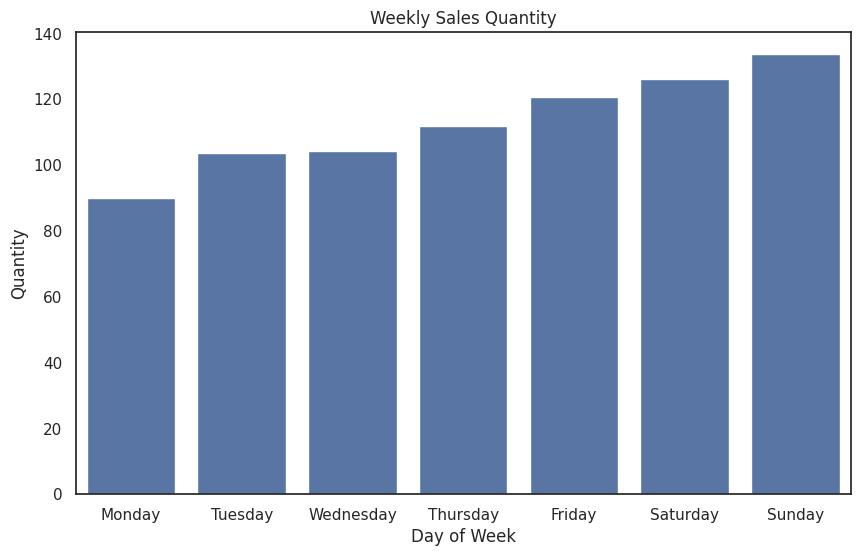

In [ ]:
# 막대 그래프 그리기
plt.figure(figsize=(10, 6))  # 그래프 크기 설정

sns.barplot(x='Weekday', y='Qty', data=a_sales_w)

# 제목과 축 레이블 추가
plt.title('Weekly Sales Quantity')
plt.xlabel('Day of Week')
plt.ylabel('Quantity')

plt.show()

※ 가설) 월-일로 갈수록 농작물 판매량이 증가할 것이다.

### 3) 시계열 데이터 분해

In [ ]:
def decomp_plot(Product_ID, sdate, edate, period) :

    # 시계열 데이터 분해
    temp = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'] == Product_ID) & (sales['Date'].between(sdate, edate))]
    decomp = sm.tsa.seasonal_decompose(temp['Qty'], model = 'additive', period = period)

    # 시계열 분해 결과를 받아서 데이터프레임으로 저장
    result = pd.DataFrame({'observed':decomp.observed, 'trend':decomp.trend, 'seasonal':decomp.seasonal, 'residual':decomp.resid})

    # 4개의 그래프로 나눠서 그리기
    plt.figure(figsize=(15, 8))

    plt.subplot(4,1,1)
    plt.plot(result['observed'])
    plt.ylabel('observed')

    plt.subplot(4,1,2)
    plt.plot(result['trend'])
    plt.ylabel('trend')

    plt.subplot(4,1,3)
    plt.plot(result['seasonal'])
    plt.ylabel('seasonal')

    plt.subplot(4,1,4)
    plt.plot(result['residual'])
    plt.ylabel('residual')
    plt.show()

    return result

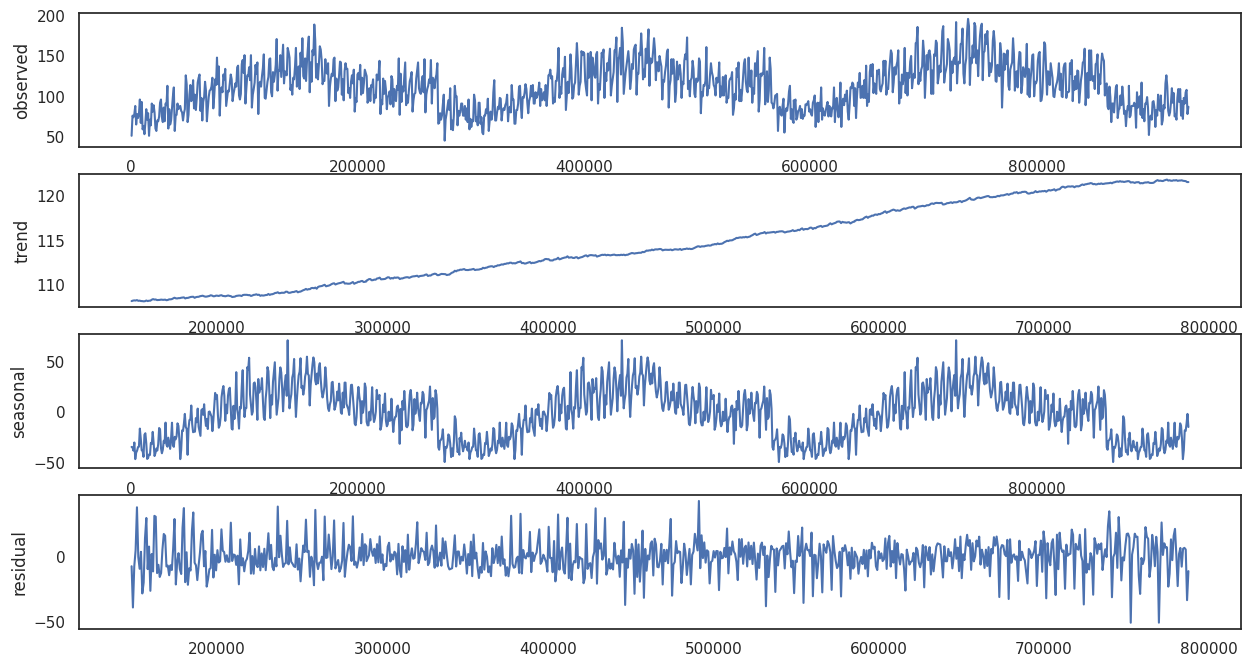

In [ ]:
result = decomp_plot(AGRICULTURAL_PRODUCTS_ID, start_date, end_date, 365)

- 점점 판매량은 증가하는 추세

### 4) 그 외 패턴 찾아보기

# **3.패턴 정리하기**

* 다양한 탐색을 통해 찾은 시계열 패턴을 적어 봅시다.

    - 기후에 따라, 농작물 생산량이 증가하는 여름에 판매량이 증가, 겨울에 감소한 것일 것이며, 수요량에도 영향을 줬을 것이다.
    - 해산물, 계란, 고기의 판매량이 증가할수록 농작물의 판매량도 증가한다.
    - 당일 유가와 지난주 유가는 농작물 판매량과 연관이 없다.
    - 월-일로 갈수록 농작물 판매량이 증가한다.
    - 농작물 판매량은 점점 증가하는 추세이다.